# README

We are going to show the frequency that regions of the TI-TE surface are biexponential or monoexponential for different alpha values at a set SNR

I will start with one dimensional lines and eventually change this into a two dimensional surface that shows TI and alpha for a set of parameters

# Libraries

In [43]:
#Preparing all libraries
import matplotlib.pyplot as plt
import numpy as np
import scipy
from scipy.optimize import curve_fit
from scipy.optimize import minimize
import addcopyfighandler
import statistics
import math
import time
from tqdm import trange
from matplotlib import cm
import colorsys
from datetime import date
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm

# Options

In [44]:
intEnds = True           #bases TI values around integer values

# Initialization

In [45]:
######All Fixed parameters for code
#Parameters held constant
c1 = 0.4
c2 = 0.6 #0.5
T21 = 40
T22 = 100
T11 = 600
T12 = 1200

true_params = np.array([T11, T12, c1, c2, T21, T22])

multi_starts_BIC = 3

#Preparing TI array to loop through
TI1star = np.log(2)*T11
TI2star = np.log(2)*T12

nTE = 64
dTE = 8
TE_DATA = np.linspace(dTE, dTE*nTE, nTE) #ms units
assert(TE_DATA[-1] == dTE*nTE)

SNR_value = 100

alpha_label = r"\alpha"
alpha_array = np.linspace(0.90, 1.0, 25)

repetition = 100

#Information determing TI range
nullResolution = 10
nullRadius = 205  #20

#Preparing TI array to loop through
TI1star = np.log(2)*T11
TI2star = np.log(2)*T12

upper_TI = np.floor(TI2star) + nullRadius
lower_TI = np.floor(TI1star) - nullRadius

TI_DATA = np.arange(lower_TI, upper_TI+nullResolution, nullResolution)

ParamTitle_6p = [r'$T_{11}$', r'$T_{12}$', r'$c_1$', r'$c_2$', r'$T_{21}$', r'$T_{22}$']

# Theoretical RSS coefficients
R0_coeff_TI1 = (c1**2 * T21 *(T21 - T22)**4)/(2*T11**2 * (T21 + T22)**4)
R0_coeff_TI2 = (c2**2 * T22 *(T21 - T22)**4)/(2*T12**2 * (T21 + T22)**4)

# Functions

In [46]:
#Defining the function of interest

def S_biX_6p(TE, T11, T12, c1, c2, T21, T22, TI = 0):
    exp1 = c1*(1-2*np.exp(-TI/T11))*np.exp(-TE/T21)
    exp2 = c2*(1-2*np.exp(-TI/T12))*np.exp(-TE/T22)
    return exp1 + exp2

#All curves get noise according to this equation
def add_noise(data, SNR):
    #returns a noised vector of data using the SNR given
    sigma = (c1+c2)/SNR #np.max(np.abs(data))/SNR
    noise = np.random.normal(0,sigma,data.shape)
    noised_data = data + noise
    return noised_data

#The one dimensional models are used to evaluate if a curve is more likely monoX or biX
def S_biX_4p(TE, d1, d2, T21, T22):
    exp1 = d1*np.exp(-TE/T21)
    exp2 = d2*np.exp(-TE/T22)
    return exp1 + exp2

def S_moX_2p(TE, d, T2):
    return d*np.exp(-TE/T2)

In [47]:
def BIC_calc(RSS, TE_array, p_list, sigma):

    BIC = 1/len(TE_array) * (RSS + np.log(len(TE_array))*len(p_list)*(sigma)**2)

    return BIC

def BIC_int_lengh_calc(R0, num_TE, diff_TE, SNR, alpha):
    return (((4-2*alpha)*(np.log(num_TE)-1) + (1-alpha)*num_TE)*diff_TE/(R0*SNR**2))**(1/2)

def get_func_bounds(func):
    f_name = func.__name__
    if f_name == "S_biX_6p":
        lower_bound = (2, 2, 0, 0, 2, 2)
        upper_bound = (2000, 2000, 1, 1, 150, 150)
    elif f_name == "S_moX_3p":
        lower_bound = (2, 0, 2)
        upper_bound = (2000, 1, 150)
    elif f_name == "S_biX_4p":
        lower_bound = (-1, -1, 2, 2)
        upper_bound = (1, 1, 150, 150)
    elif f_name == "S_moX_2p":
        lower_bound = (-1, 2)
        upper_bound = (1, 150)
    else:
        raise Exception("Not a valid function: " + f_name)

    return lower_bound, upper_bound

def set_p0(func, random = True):
    true_params = [T11, T12, c1, c2, T21, T22]
    if random:
        lb, ub = get_func_bounds(func)
        if func.__name__.find("S_biX_6p") > -1:
            T11_est = np.random.uniform(lb[-6],ub[-6])
            T12_est = np.random.uniform(T11_est,ub[-5])
            c1_est = np.random.uniform(lb[-4],ub[-4])
            T21_est = np.random.uniform(lb[-2],ub[-2])
            T22_est = np.random.uniform(T21_est,ub[-1])
            p0 = [T11_est, T12_est, c1_est, 1-c1_est, T21_est, T22_est]
        else:
            p0 = [np.random.uniform(lb[i],ub[i]) for i in range(len(lb))]
    else:
        # f_name = func.__name__
        # if f_name.find("moX") > -1:
        #     p0 = [75, 0.5, 75]
        # elif f_name.find("biX") > -1:
        #     p0 = [75, 75, 0.5, 0.5, 75, 75]
        # else:
        p0 = true_params
            
    return p0

def check_param_order(popt):
    #Reshaping of array to ensure that the parameter pairs all end up in the appropriate place - ensures that T22 > T21
    if (popt[-1] < popt[-2]): #We want by convention to make sure that T21 is <= T22
        for pi in range(np.size(popt)//2):
            p_hold = popt[2*pi]
            popt[2*pi] = popt[2*pi+1]
            popt[2*pi+1] = p_hold
    return popt

def calculate_RSS(func, popt, data):
    est_curve = func(TE_DATA, *popt)
    RSS = np.sum((est_curve - data)**2)
    
    return RSS

def estP_oneCurve(func, noisey_data):

    init_p = set_p0(func, random = True)
    lb, ub = get_func_bounds(func)

    popt, _ = curve_fit(func, TE_DATA, noisey_data, p0 = init_p, bounds = [lb,ub], method = 'trf', maxfev = 1500)
    popt = check_param_order(popt)
    RSS = calculate_RSS(func, popt, noisey_data)

    return popt, RSS

def evaluate_model(data, SNR, alpha, ms_iter = multi_starts_BIC):

    #Returns true if the moX is better than the biX --> returns a 1 for moX and a 0 for biX
    #Returns the parameters of the correct answer

    RSS_biX = np.inf
    RSS_moX = np.inf

    for ms in range(ms_iter):
        popt_biX_temp, RSS_biX_temp = estP_oneCurve(S_biX_4p, data)
        popt_moX_temp, RSS_moX_temp = estP_oneCurve(S_moX_2p, data)

        if RSS_biX_temp < RSS_biX:
            popt_biX = popt_biX_temp
            RSS_biX = RSS_biX_temp

        if RSS_moX_temp < RSS_moX:
            popt_moX = popt_moX_temp
            RSS_moX = RSS_moX_temp

    # popt_biX, RSS_biX = estP_oneCurve(S_biX_4p, data)
    # popt_moX, RSS_moX = estP_oneCurve(S_moX_2p, data)

    BIC_biX = BIC_calc(RSS_biX, TE_DATA, popt_biX, 1/SNR)
    BIC_moX = BIC_calc(RSS_moX, TE_DATA, popt_moX, 1/SNR)

    if BIC_moX < alpha*BIC_biX:
        return True, popt_moX, RSS_moX
    else:
        return False, popt_biX, RSS_biX

# Generating Data

In [48]:
all_data = np.zeros((TI_DATA.shape[0], TE_DATA.shape[0]))

for iTI in range(TI_DATA.shape[0]):
    all_data[iTI,:] = S_biX_6p(TE_DATA, *true_params, TI = TI_DATA[iTI])

# noised_data = add_noise(all_data, SNR_value)

In [49]:
freq_array = np.zeros(TI_DATA.shape[0])

for iTI in trange(TI_DATA.shape[0]):
    counter = 0
    for rep in range(repetition):
        noisy_curve = add_noise(all_data[iTI, :], SNR_value)
        moX_opt, _, _ = evaluate_model(noisy_curve, SNR_value, alpha_array[-1])
        if moX_opt:
            counter += 1
    
    freq_array[iTI] = counter/repetition

100%|██████████| 84/84 [08:36<00:00,  6.15s/it]


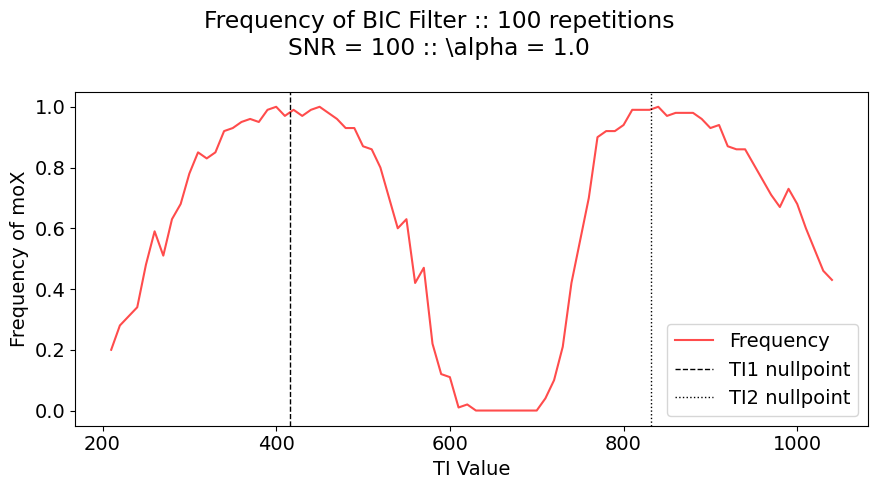

In [50]:
plt.rc('font', size = 14)
fig, ax = plt.subplots(1,1, figsize=(9,5), tight_layout=True)
fig.suptitle(f'Frequency of BIC Filter :: {repetition} repetitions\nSNR = {SNR_value} :: {alpha_label} = {alpha_array[-1]}')


ax.plot(TI_DATA, freq_array, alpha = 0.7, color = 'r', label = 'Frequency')

ax.axvline(x=TI1star, linewidth=1, label= 'TI1 nullpoint', color='k', ls = '--')
ax.axvline(x=TI2star, linewidth=1, label= 'TI2 nullpoint', color='k', ls = ':')

ax.set_xlabel('TI Value')
ax.set_ylabel('Frequency of moX')
# ax.set_title('TI1 nullpoint')
ax.legend()

plt.show()

# SNR vs. TI Array

In [51]:
freq_array_2D = np.zeros((TI_DATA.shape[0], alpha_array.shape[0]))

for iAlp in range(alpha_array.shape[0]):
    alp_temp = alpha_array[iAlp]
    for iTI in trange(TI_DATA.shape[0]):
        counter = 0
        for rep in range(repetition):
            noisy_curve = add_noise(all_data[iTI, :], SNR_value)
            moX_opt, _, _ = evaluate_model(noisy_curve, SNR_value, alp_temp)
            if moX_opt:
                counter += 1
        
        freq_array_2D[iTI, iAlp] = counter/repetition

    print(f"Finished {alpha_label} = {alpha_array[iAlp]} :: Completed {iAlp+1} {alpha_label} values of {alpha_array.shape[0]}")

100%|██████████| 84/84 [08:21<00:00,  5.98s/it]


Finished \alpha = 0.9 :: Completed 1 \alpha values of 25


100%|██████████| 84/84 [08:20<00:00,  5.96s/it]


Finished \alpha = 0.9041666666666667 :: Completed 2 \alpha values of 25


100%|██████████| 84/84 [08:18<00:00,  5.93s/it]


Finished \alpha = 0.9083333333333333 :: Completed 3 \alpha values of 25


100%|██████████| 84/84 [08:22<00:00,  5.98s/it]


Finished \alpha = 0.9125 :: Completed 4 \alpha values of 25


100%|██████████| 84/84 [08:29<00:00,  6.07s/it]


Finished \alpha = 0.9166666666666667 :: Completed 5 \alpha values of 25


100%|██████████| 84/84 [08:30<00:00,  6.08s/it]


Finished \alpha = 0.9208333333333334 :: Completed 6 \alpha values of 25


100%|██████████| 84/84 [08:35<00:00,  6.14s/it]


Finished \alpha = 0.925 :: Completed 7 \alpha values of 25


100%|██████████| 84/84 [08:32<00:00,  6.10s/it]


Finished \alpha = 0.9291666666666667 :: Completed 8 \alpha values of 25


100%|██████████| 84/84 [08:33<00:00,  6.11s/it]


Finished \alpha = 0.9333333333333333 :: Completed 9 \alpha values of 25


100%|██████████| 84/84 [08:34<00:00,  6.13s/it]


Finished \alpha = 0.9375 :: Completed 10 \alpha values of 25


100%|██████████| 84/84 [08:27<00:00,  6.05s/it]


Finished \alpha = 0.9416666666666667 :: Completed 11 \alpha values of 25


100%|██████████| 84/84 [08:25<00:00,  6.02s/it]


Finished \alpha = 0.9458333333333333 :: Completed 12 \alpha values of 25


100%|██████████| 84/84 [08:29<00:00,  6.06s/it]


Finished \alpha = 0.95 :: Completed 13 \alpha values of 25


100%|██████████| 84/84 [08:31<00:00,  6.09s/it]


Finished \alpha = 0.9541666666666667 :: Completed 14 \alpha values of 25


100%|██████████| 84/84 [08:30<00:00,  6.08s/it]


Finished \alpha = 0.9583333333333334 :: Completed 15 \alpha values of 25


100%|██████████| 84/84 [08:26<00:00,  6.03s/it]


Finished \alpha = 0.9625 :: Completed 16 \alpha values of 25


100%|██████████| 84/84 [08:35<00:00,  6.14s/it]


Finished \alpha = 0.9666666666666667 :: Completed 17 \alpha values of 25


100%|██████████| 84/84 [08:23<00:00,  5.99s/it]


Finished \alpha = 0.9708333333333333 :: Completed 18 \alpha values of 25


100%|██████████| 84/84 [08:25<00:00,  6.01s/it]


Finished \alpha = 0.975 :: Completed 19 \alpha values of 25


100%|██████████| 84/84 [08:25<00:00,  6.02s/it]


Finished \alpha = 0.9791666666666666 :: Completed 20 \alpha values of 25


100%|██████████| 84/84 [08:30<00:00,  6.08s/it]


Finished \alpha = 0.9833333333333334 :: Completed 21 \alpha values of 25


100%|██████████| 84/84 [08:18<00:00,  5.94s/it]


Finished \alpha = 0.9875 :: Completed 22 \alpha values of 25


100%|██████████| 84/84 [08:29<00:00,  6.07s/it]


Finished \alpha = 0.9916666666666667 :: Completed 23 \alpha values of 25


100%|██████████| 84/84 [08:26<00:00,  6.03s/it]


Finished \alpha = 0.9958333333333333 :: Completed 24 \alpha values of 25


100%|██████████| 84/84 [08:30<00:00,  6.08s/it]

Finished \alpha = 1.0 :: Completed 25 \alpha values of 25


In [52]:
mAlp, mTI = np.meshgrid(alpha_array, TI_DATA)

print(f"Shape of TI Data = {TI_DATA.shape} and shape of alpha_array = {alpha_array.shape}")
print(f"mesh shape = {mTI.shape}")
print(f"First value in TI mesh = {mTI[0,0]}")

Shape of TI Data = (84,) and shape of alpha_array = (25,)
mesh shape = (84, 25)
First value in TI mesh = 210.0


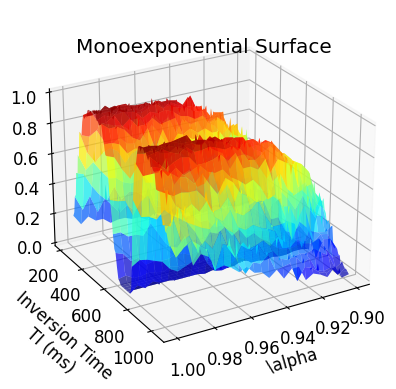

In [53]:


fig = plt.figure(figsize = (6,4), tight_layout=True)
plt.rc('font', size = 12)
ax = plt.axes(projection='3d')
# my_col = cm.jet(sig/np.amax(sig))
ax.plot_surface(mAlp , mTI, freq_array_2D, alpha = 0.7, cmap = cm.jet)
ax.view_init(25,60)
# ax.xaxis.labelpad = 15
ax.yaxis.labelpad = 12
# ax.zaxis.labelpad = 9

ax.set_ylabel('Inversion Time\nTI (ms)')
ax.set_xlabel(f'{alpha_label}')
# ax.set_zlabel('Signal')
ax.set_title('Monoexponential Surface', y=1.0, pad=-10)
# ax.dist = 12

plt.show()

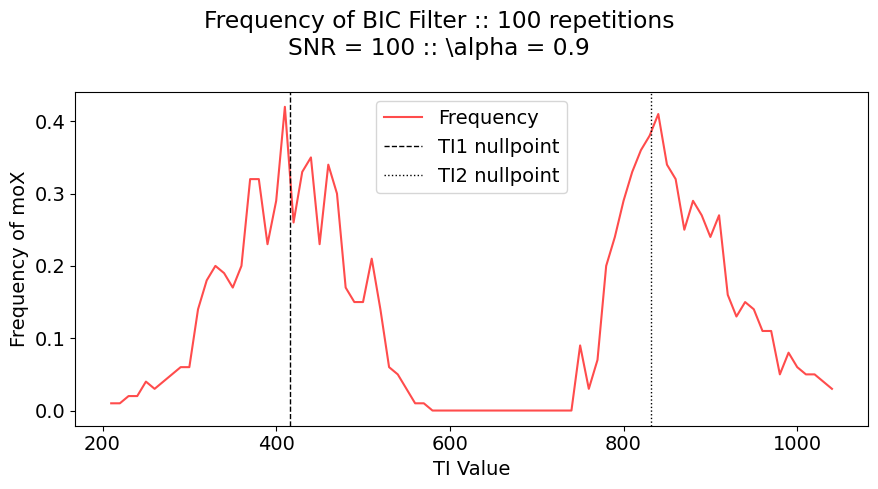

In [54]:
alpha_select = 0

plt.rc('font', size = 14)
fig, ax = plt.subplots(1,1, figsize=(9,5), tight_layout=True)
fig.suptitle(f'Frequency of BIC Filter :: {repetition} repetitions\nSNR = {SNR_value} :: {alpha_label} = {alpha_array[alpha_select]}')


ax.plot(TI_DATA, freq_array_2D[:,alpha_select], alpha = 0.7, color = 'r', label = 'Frequency')

ax.axvline(x=TI1star, linewidth=1, label= 'TI1 nullpoint', color='k', ls = '--')
ax.axvline(x=TI2star, linewidth=1, label= 'TI2 nullpoint', color='k', ls = ':')

ax.set_xlabel('TI Value')
ax.set_ylabel('Frequency of moX')
# ax.set_title('TI1 nullpoint')
ax.legend()

plt.show()

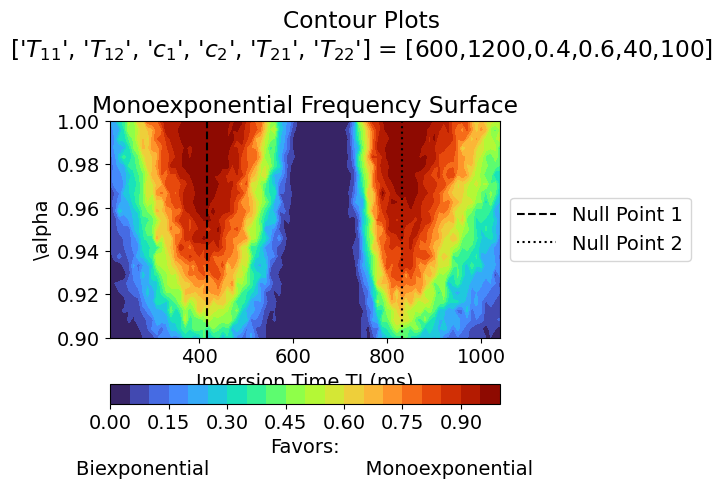

In [55]:
fig, ax = plt.subplots(1, 1, figsize=(7,5), tight_layout=True)
fig.suptitle(f"Contour Plots\n{ParamTitle_6p} = [{T11},{T12},{c1},{c2},{T21},{T22}]")

cp = ax.contourf( np.matrix.transpose(mTI), np.matrix.transpose(mAlp), np.matrix.transpose(freq_array_2D), 20, cmap = 'turbo')
ax.axvline(x=TI1star, color = 'k', ls = '--', label = 'Null Point 1')
ax.axvline(x=TI2star, color = 'k', ls = ':', label = 'Null Point 2')

ax.set_xlabel('Inversion Time TI (ms)')
ax.set_ylabel(f'{alpha_label}')
ax.set_title('Monoexponential Frequency Surface')
fig.colorbar(cp, ax = ax, location = 'bottom', label = "Favors:\nBiexponential                         Monoexponential")
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [56]:
moX_reg_T1 = BIC_int_lengh_calc(R0_coeff_TI1, nTE, dTE, SNR_value, alpha_array)
moX_reg_T1_low = TI1star - moX_reg_T1
moX_reg_T1_high = TI1star + moX_reg_T1

moX_reg_T2 = BIC_int_lengh_calc(R0_coeff_TI2, nTE, dTE, SNR_value, alpha_array)
moX_reg_T2_low = TI2star - moX_reg_T2
moX_reg_T2_high = TI2star + moX_reg_T2

cross_index = np.where(moX_reg_T1_high<moX_reg_T2_low)[0][0]
# print(cross_index)

x_array = np.concatenate((moX_reg_T1_low, np.flip(moX_reg_T1_high), moX_reg_T2_low, np.flip(moX_reg_T2_high)))
y_array = np.concatenate((np.flip(alpha_array), alpha_array, np.flip(alpha_array), alpha_array))

#Overcome any Criss Cross
# x_array = np.concatenate((moX_reg_T1_low, np.flip(moX_reg_T1_high[(cross_index-1):]), moX_reg_T2_low[cross_index:], np.flip(moX_reg_T2_high)))
# y_array = np.concatenate((alpha_array, np.flip(alpha_array[(cross_index-1):]), alpha_array[cross_index:], np.flip(alpha_array)))

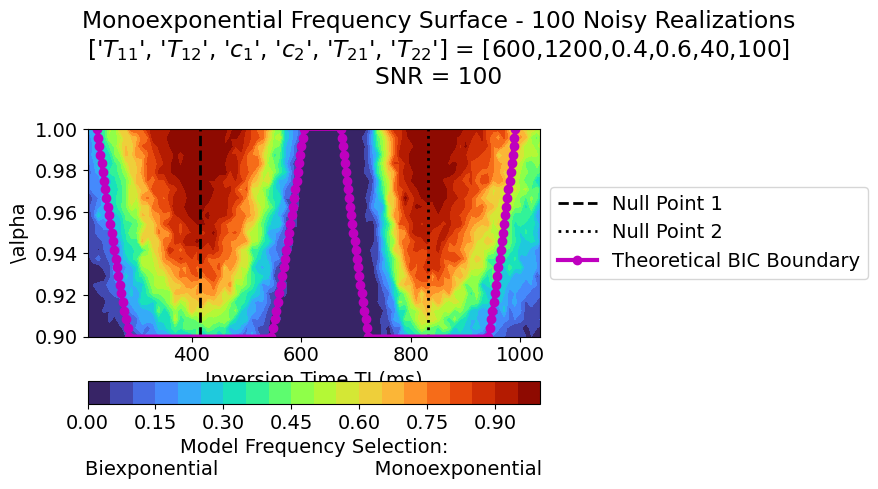

In [57]:
fig, ax = plt.subplots(1, 1, figsize=(9,5), tight_layout=True)
fig.suptitle(f"Monoexponential Frequency Surface - {repetition} Noisy Realizations\n{ParamTitle_6p} = [{T11},{T12},{c1},{c2},{T21},{T22}]\nSNR = {SNR_value}")

cp = ax.contourf( np.matrix.transpose(mTI), np.matrix.transpose(mAlp), np.matrix.transpose(freq_array_2D), 20, cmap = 'turbo')
ax.axvline(x=TI1star, color = 'k', ls = '--', label = 'Null Point 1', lw = 2)
ax.axvline(x=TI2star, color = 'k', ls = ':', label = 'Null Point 2', lw = 2)
ax.plot(x_array, y_array, color =  'm', lw = 3, label = 'Theoretical BIC Boundary', marker = 'o')
ax.set_xlim([lower_TI, upper_TI])

ax.set_xlabel('Inversion Time TI (ms)')
ax.set_ylabel(f'{alpha_label}')
# ax.set_title('')
fig.colorbar(cp, ax = ax, location = 'bottom', label = "Model Frequency Selection:\nBiexponential                         Monoexponential")
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))